In [2]:
import os 
import xarray as xr
import numpy as np
import glob
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, normalize
import itertools
from numpy.lib.stride_tricks import sliding_window_view
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator
import matplotlib.gridspec as gridspec
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
from scipy.stats import pearsonr
import utils_results as ut

In [3]:
# Set directories
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
fs_dir = os.path.join(project_dir, 'FS_TCG')
results_dir = os.path.join(fs_dir, 'results')

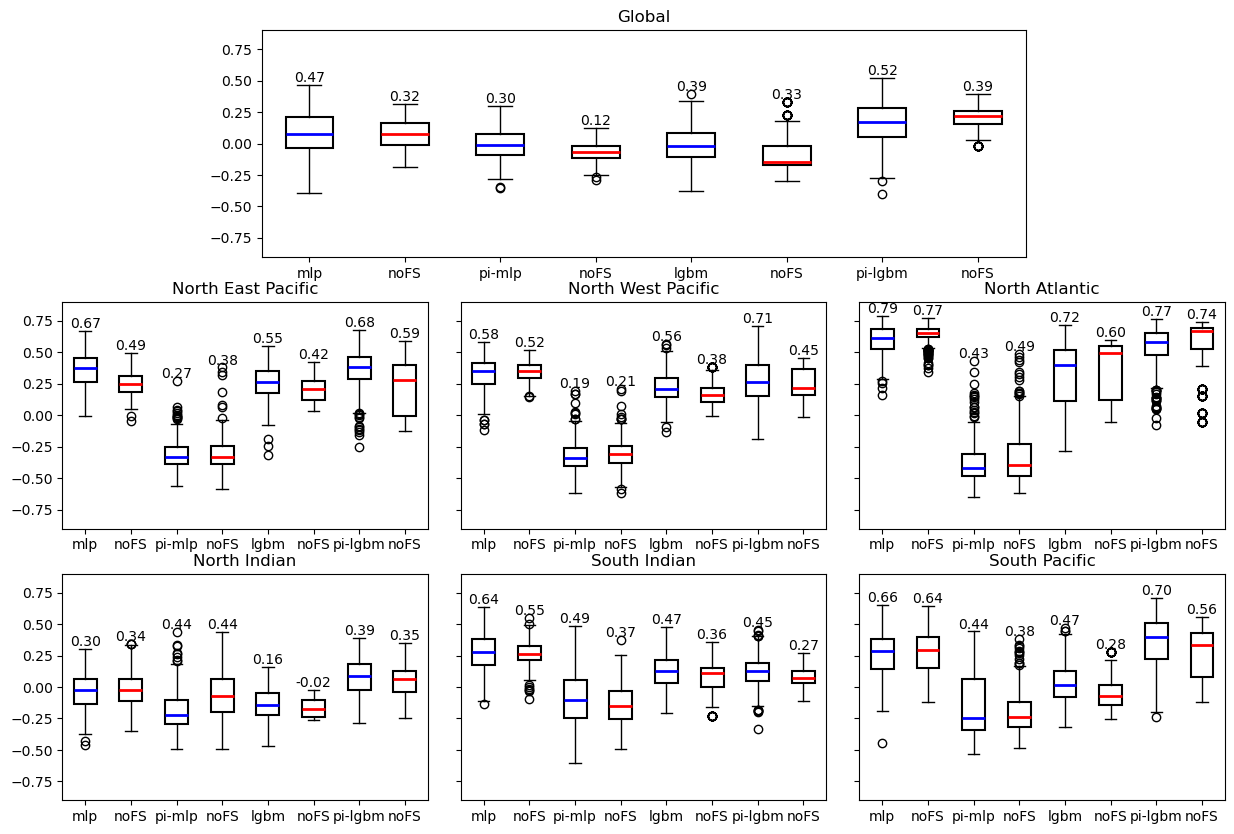

In [4]:
fmod_boxplot_fig = plt.figure(figsize=(15, 10))
fmod_gs = gridspec.GridSpec(3, 6, figure=fmod_boxplot_fig)
basin_names = ['Global', 'North East Pacific', 'North West Pacific', 'North Atlantic', 'North Indian', 'South Indian', 'South Pacific']
for bb, basin in enumerate(['GLB', 'NEP', 'NWP', 'NA', 'NI', 'SI', 'SP']):
    # Load file keeping track of the performance of the simulations
    track_file = os.path.join(results_dir, f'sim_performance_{basin}.csv')
    track_df = pd.read_csv(track_file, index_col=0)
    track_df = track_df[track_df.index.str.contains('nd9')]
    # Cycle through the different finals models 
    performance_col = ['R_Y_mlp', 'R_Y_mlp_noFS', 'R_Y_pi-mlp', 'R_Y_pi-mlp_noFS', 'R_Y_lgbm', 'R_Y_lgbm_noFS', 'R_Y_pi-lgbm', 'R_Y_pi-lgbm_noFS']
    performance_arrays = []
    best_values = []
    for performance in performance_col:
        sorted_df = track_df.sort_values(performance, ascending=False)
        performance_arrays.append(sorted_df[performance].values)
        best_values.append(sorted_df[performance].values[0])
    # Plot the boxplot of the performance of the simulations
    if basin == 'GLB':
        ax = fmod_boxplot_fig.add_subplot(fmod_gs[0,1:5])
    elif basin == 'NEP':
        ax = fmod_boxplot_fig.add_subplot(fmod_gs[1,0:2])
    elif basin == 'NWP':
        ax = fmod_boxplot_fig.add_subplot(fmod_gs[1,2:4])
        ax.set_yticklabels([])
    elif basin == 'NA':
        ax = fmod_boxplot_fig.add_subplot(fmod_gs[1,4:])
        ax.set_yticklabels([])
    elif basin == 'NI':
        ax = fmod_boxplot_fig.add_subplot(fmod_gs[2,0:2])
    elif basin == 'SI':
        ax = fmod_boxplot_fig.add_subplot(fmod_gs[2,2:4])
        ax.set_yticklabels([])
    elif basin == 'SP':
        ax = fmod_boxplot_fig.add_subplot(fmod_gs[2,4:])
        ax.set_yticklabels([])
    box = ax.boxplot(performance_arrays, labels=['mlp', 'noFS', 'pi-mlp', 'noFS', 'lgbm', 'noFS', 'pi-lgbm', 'noFS'],
                        showfliers=True, patch_artist=True)
    colors = ["blue", "red", "blue", "red", "blue", "red", "blue", "red"]
    for median, color in zip(box['medians'], colors):
        median.set(color=color, linewidth=2)
    for b in box['boxes']:
        b.set(facecolor='white', edgecolor='black', linewidth=1.5)
    # Add the best performance values to the plot
    for i, value in enumerate(best_values):
        ax.text(i+1, value, f'{value:.2f}', ha='center', va='bottom', fontsize=10)
    ax.set_title(f'{basin_names[bb]}')
    ax.set_ylim([-0.9, 0.9]);

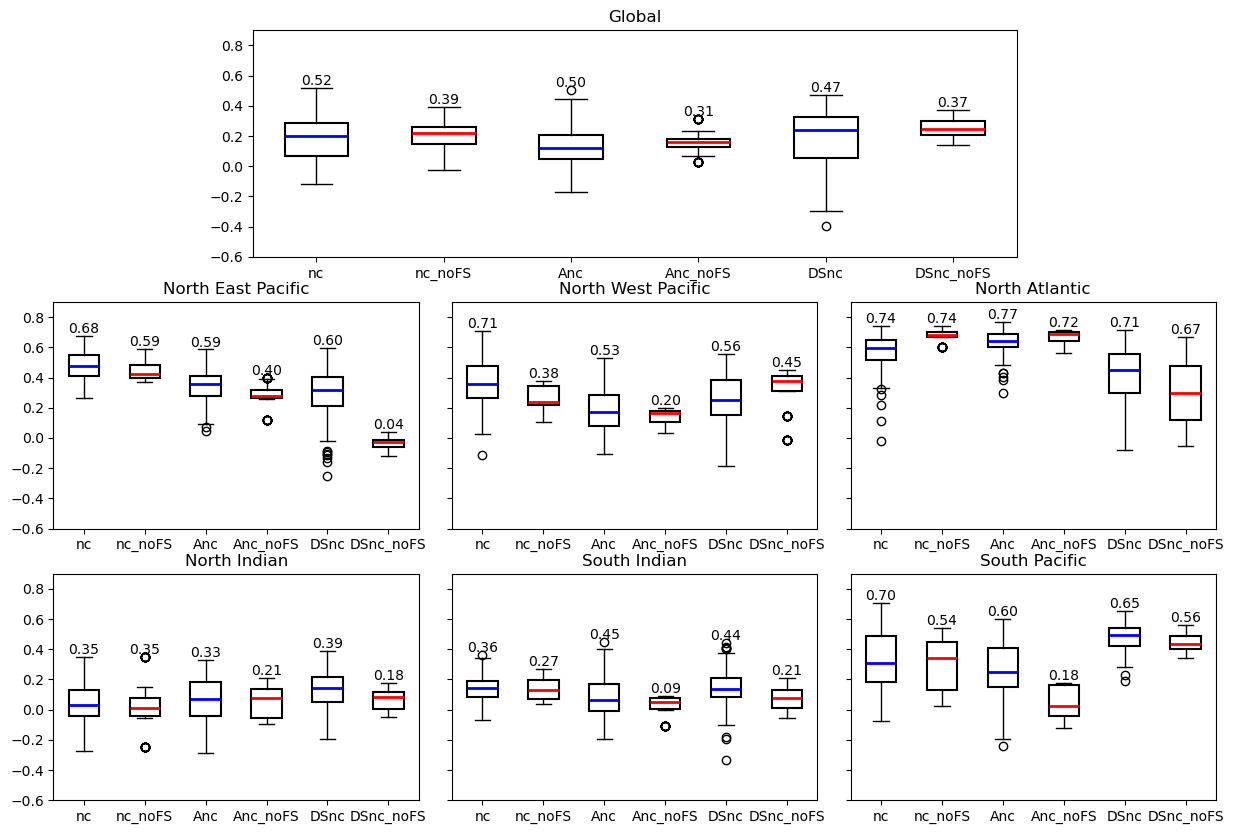

In [9]:
FINAL_MODEL = 'pi-lgbm'
# Boxplot considering the different cluster types
cltype_boxplot_fig = plt.figure(figsize=(15, 10))
cltype_gs = gridspec.GridSpec(3, 6, figure=cltype_boxplot_fig)
basin_names = ['Global', 'North East Pacific', 'North West Pacific', 'North Atlantic', 'North Indian', 'South Indian', 'South Pacific']
for bb, basin in enumerate(['GLB', 'NEP', 'NWP', 'NA', 'NI', 'SI', 'SP']):
    # Load file keeping track of the performance of the simulations
    track_file = os.path.join(results_dir, f'sim_performance_{basin}.csv')
    track_df = pd.read_csv(track_file, index_col=0)
    track_df = track_df[track_df.index.str.contains('nd9')]
    # Sort the dataframe by the performance of the chosen final model
    performance_col = f'R_Y_{FINAL_MODEL}'
    sorted_df = track_df.sort_values(performance_col, ascending=False)
    performance_col_noFS = f'R_Y_{FINAL_MODEL}_noFS'
    sorted_df_noFS = track_df.sort_values(performance_col_noFS, ascending=False)
    # Extract the simulation considering the 3 different cluster types
    sorted_df_nc = sorted_df[sorted_df.index.str.contains('_nc')]
    sorted_df_Anc = sorted_df[sorted_df.index.str.contains('_Anc')]
    sorted_df_DSnc = sorted_df[sorted_df.index.str.contains('_DSnc')]
    sorted_df_noFS_nc = sorted_df_noFS[sorted_df_noFS.index.str.contains('_nc')]
    sorted_df_noFS_Anc = sorted_df_noFS[sorted_df_noFS.index.str.contains('_Anc')]
    sorted_df_noFS_DSnc = sorted_df_noFS[sorted_df_noFS.index.str.contains('_DSnc')]
    # Get the best performance values for each cluster type
    best_values = [
        sorted_df_nc.iloc[0][performance_col], sorted_df_noFS_nc.iloc[0][performance_col_noFS],
        sorted_df_Anc.iloc[0][performance_col], sorted_df_noFS_Anc.iloc[0][performance_col_noFS],
        sorted_df_DSnc.iloc[0][performance_col], sorted_df_noFS_DSnc.iloc[0][performance_col_noFS]
    ]
    # Plot the boxplot of the performance of the simulations
    if basin == 'GLB':
        ax = cltype_boxplot_fig.add_subplot(cltype_gs[0,1:5])
    elif basin == 'NEP':
        ax = cltype_boxplot_fig.add_subplot(cltype_gs[1,0:2])
    elif basin == 'NWP':
        ax = cltype_boxplot_fig.add_subplot(cltype_gs[1,2:4])
        ax.set_yticklabels([])
    elif basin == 'NA':
        ax = cltype_boxplot_fig.add_subplot(cltype_gs[1,4:])
        ax.set_yticklabels([])
    elif basin == 'NI':
        ax = cltype_boxplot_fig.add_subplot(cltype_gs[2,0:2])
    elif basin == 'SI':
        ax = cltype_boxplot_fig.add_subplot(cltype_gs[2,2:4])
        ax.set_yticklabels([])
    elif basin == 'SP':
        ax = cltype_boxplot_fig.add_subplot(cltype_gs[2,4:])
        ax.set_yticklabels([])
    box = ax.boxplot([sorted_df_nc[performance_col].values, sorted_df_noFS_nc[performance_col_noFS].values,
                        sorted_df_Anc[performance_col].values, sorted_df_noFS_Anc[performance_col_noFS].values,
                        sorted_df_DSnc[performance_col].values, sorted_df_noFS_DSnc[performance_col_noFS].values],
                        labels=['nc', 'nc_noFS', 'Anc', 'Anc_noFS', 'DSnc', 'DSnc_noFS'],
                        showfliers=True, patch_artist=True)
    colors = ["blue", "red", "blue", "red", "blue", "red"]
    for median, color in zip(box['medians'], colors):
        median.set(color=color, linewidth=2)
    for b in box['boxes']:
        b.set(facecolor='white', edgecolor='black', linewidth=1.5)
    # Add the best performance values to the plot
    for i, value in enumerate(best_values):
        ax.text(i+1, value, f'{value:.2f}', ha='center', va='bottom', fontsize=10)
    ax.set_title(f'{basin_names[bb]}')
    ax.set_ylim([-0.6, 0.9]);
# cltype_boxplot_fig.suptitle(f'Annual correlation performances of NN models for the different cluster types', fontsize=14);

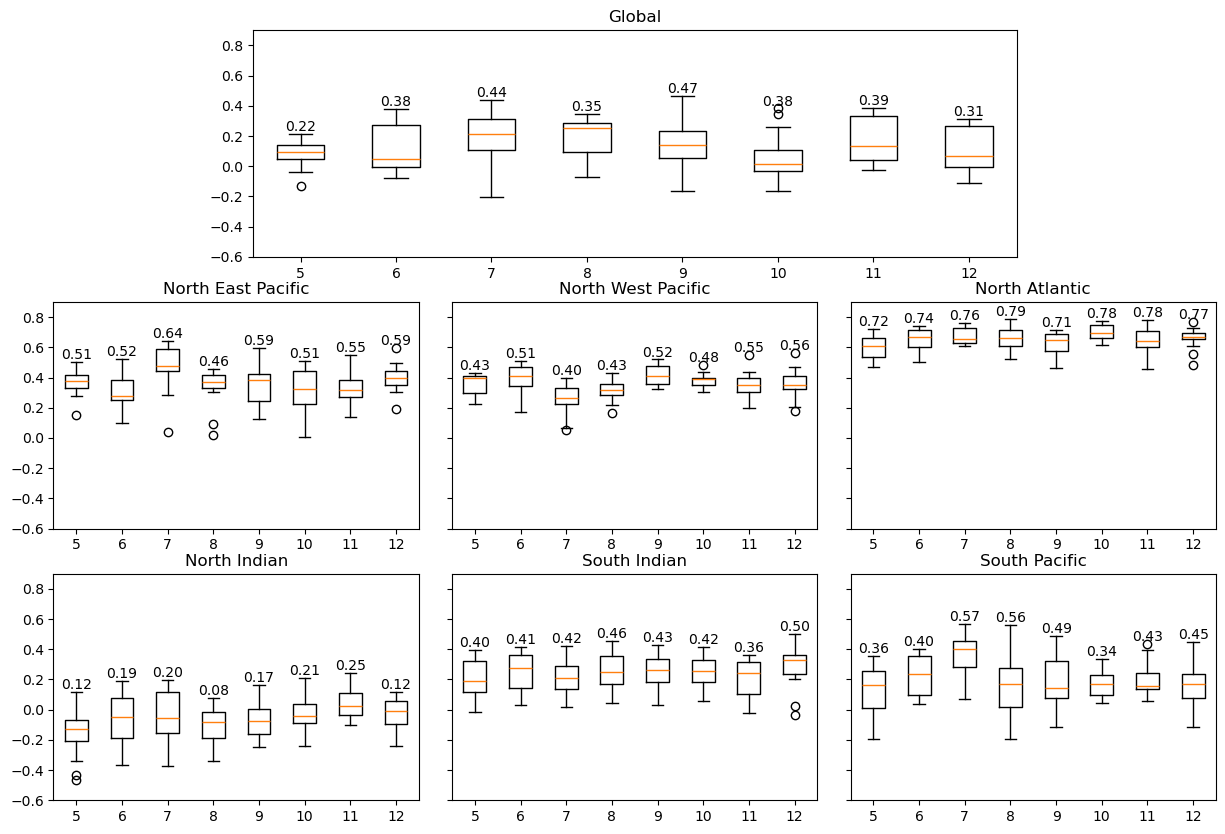

In [6]:
CLUSTER_TYPE = 'Anc'
# Boxplot considering the number of clusters
ncl_boxplot_fig = plt.figure(figsize=(15, 10))
ncle_gs = gridspec.GridSpec(3, 6, figure=ncl_boxplot_fig)
basin_names = ['Global', 'North East Pacific', 'North West Pacific', 'North Atlantic', 'North Indian', 'South Indian', 'South Pacific']
for bb, basin in enumerate(['GLB', 'NEP', 'NWP', 'NA', 'NI', 'SI', 'SP']):
    # Load file keeping track of the performance of the simulations
    track_file = os.path.join(results_dir, f'sim_performance_{basin}.csv')
    track_df = pd.read_csv(track_file, index_col=0)
    track_df = track_df[track_df.index.str.contains('nd9')]
    # Filter the track_df to keep only simulations with the anomaly cluster type
    track_df = track_df[track_df.index.str.contains(CLUSTER_TYPE)]
    # Sort the dataframe by the performance of the chosen final model
    performance_col = f'R_Y_{FINAL_MODEL}'
    sorted_df = track_df.sort_values(performance_col, ascending=False)
    # Cycle through the number of clusters and extract the data to plot the boxplot
    performances_arrays = []
    best_values = []
    for ncl in range(5, 13):
        ncl_df = sorted_df[sorted_df['n_clusters'] == ncl]
        performances_arrays.append(ncl_df[performance_col].values)
        best_values.append(ncl_df.iloc[0][performance_col])
    # Plot the boxplot of the performance of the simulations
    if basin == 'GLB':
        ax = ncl_boxplot_fig.add_subplot(ncle_gs[0,1:5])
    elif basin == 'NEP':
        ax = ncl_boxplot_fig.add_subplot(ncle_gs[1,0:2])
    elif basin == 'NWP':
        ax = ncl_boxplot_fig.add_subplot(ncle_gs[1,2:4])
        ax.set_yticklabels([])
    elif basin == 'NA':
        ax = ncl_boxplot_fig.add_subplot(ncle_gs[1,4:])
        ax.set_yticklabels([])
    elif basin == 'NI':
        ax = ncl_boxplot_fig.add_subplot(ncle_gs[2,0:2])
    elif basin == 'SI':
        ax = ncl_boxplot_fig.add_subplot(ncle_gs[2,2:4])
        ax.set_yticklabels([])
    elif basin == 'SP':
        ax = ncl_boxplot_fig.add_subplot(ncle_gs[2,4:])
        ax.set_yticklabels([])
    box = ax.boxplot(performances_arrays, labels=[str(i) for i in range(5, 13)], showfliers=True, patch_artist=False)
    # colors = ["blue", "red", "blue", "red", "blue", "red"]
    # for median, color in zip(box['medians'], colors):
    #     median.set(color=color, linewidth=2)
    # for b in box['boxes']:
    #     b.set(facecolor='white', edgecolor='black', linewidth=1.5)
    # Add the best performance values to the plot
    for i, value in enumerate(best_values):
        ax.text(i+1, value, f'{value:.2f}', ha='center', va='bottom', fontsize=10)
    ax.set_title(f'{basin_names[bb]}')
    ax.set_ylim([-0.6, 0.9]);

In [10]:
BASIN = 'GLB'
N_CLUSTERS = 9
# Load the performance file for the basin and filter to get the simulation with the best performance
track_file = os.path.join(results_dir, f'sim_performance_{BASIN}.csv')
track_df = pd.read_csv(track_file, index_col=0)
track_df = track_df[track_df.index.str.contains('nd9')]
track_df = track_df[track_df.index.str.contains(CLUSTER_TYPE)]
track_df = track_df[track_df['n_clusters'] == N_CLUSTERS]
# Get the simulation with the best performance
sorted_df = track_df.sort_values(f'R_Y_{FINAL_MODEL}', ascending=False)
best_sim = sorted_df.iloc[0]
print(f'Best NN model for {BASIN} with {N_CLUSTERS} clusters: {best_sim.name} - R_Y: {best_sim[f"R_Y_{FINAL_MODEL}"]:.2f}')
# Get the best annual correlation for a model with no features selection
sorted_df_noFS = track_df.sort_values(f'R_Y_{FINAL_MODEL}_noFS', ascending=False)
best_sim_noFS = sorted_df_noFS.iloc[0]
print(f'Best NN model for {BASIN} with {N_CLUSTERS} clusters and no FS: {best_sim_noFS.name} - R_Y: {best_sim_noFS[f"R_Y_{FINAL_MODEL}_noFS"]:.2f}')


Best NN model for GLB with 9 clusters: test1_pi-lgbm_Anc9_nv8_nd9 - R_Y: 0.39
Best NN model for GLB with 9 clusters and no FS: test1_linreg_Anc9_nv8_nd9 - R_Y: 0.15


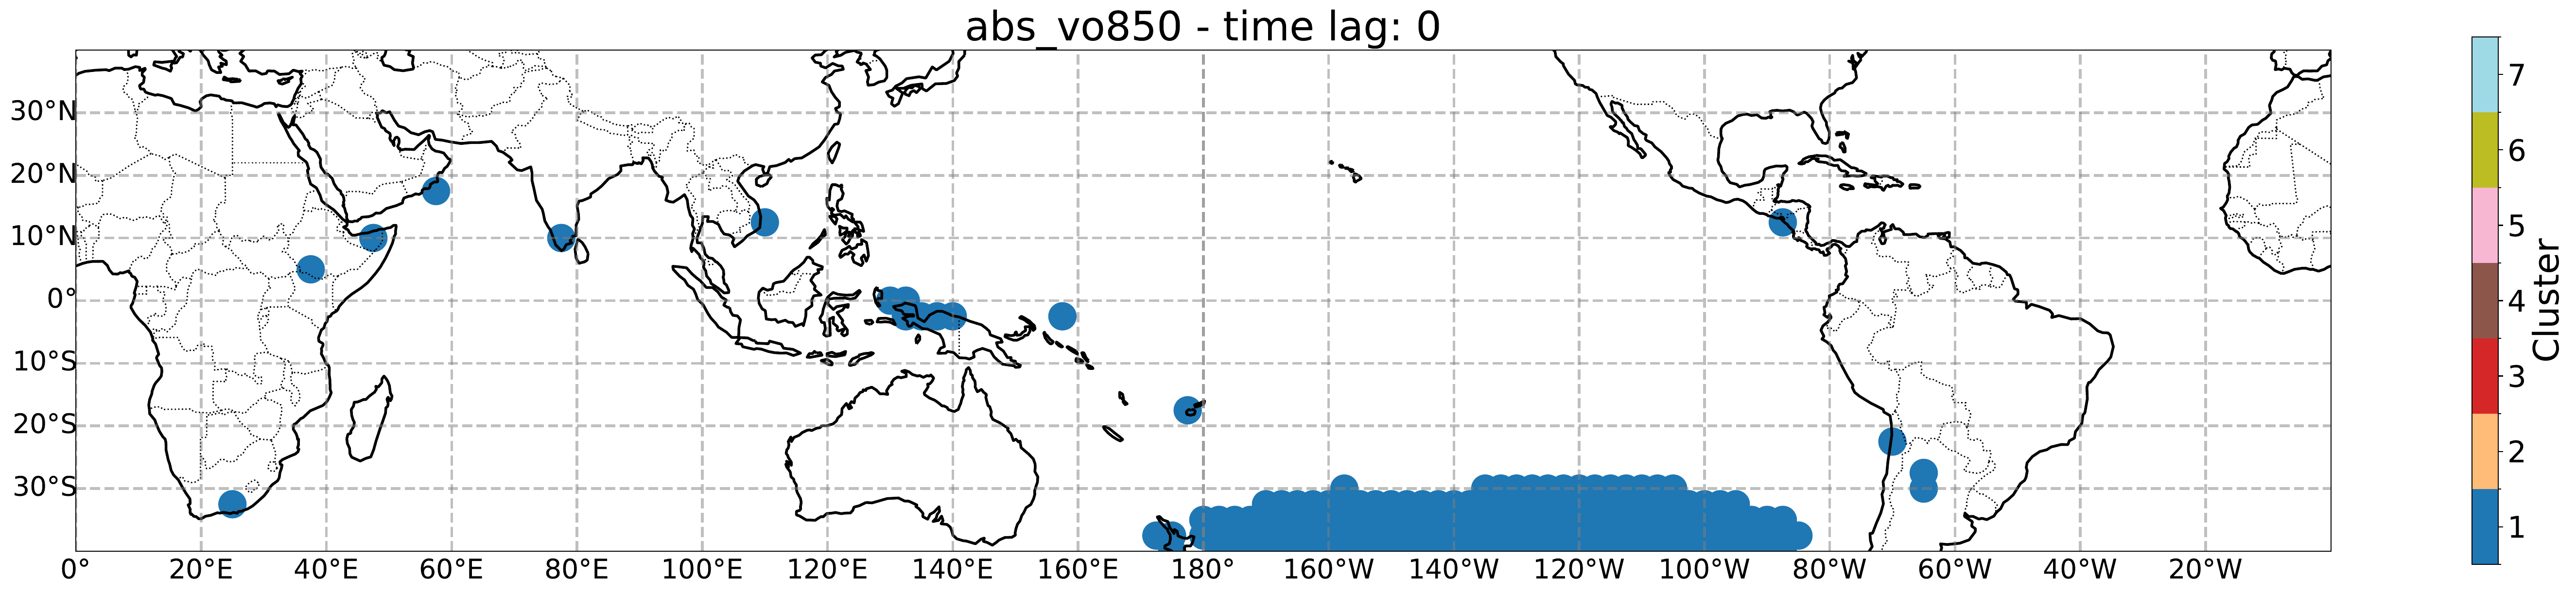

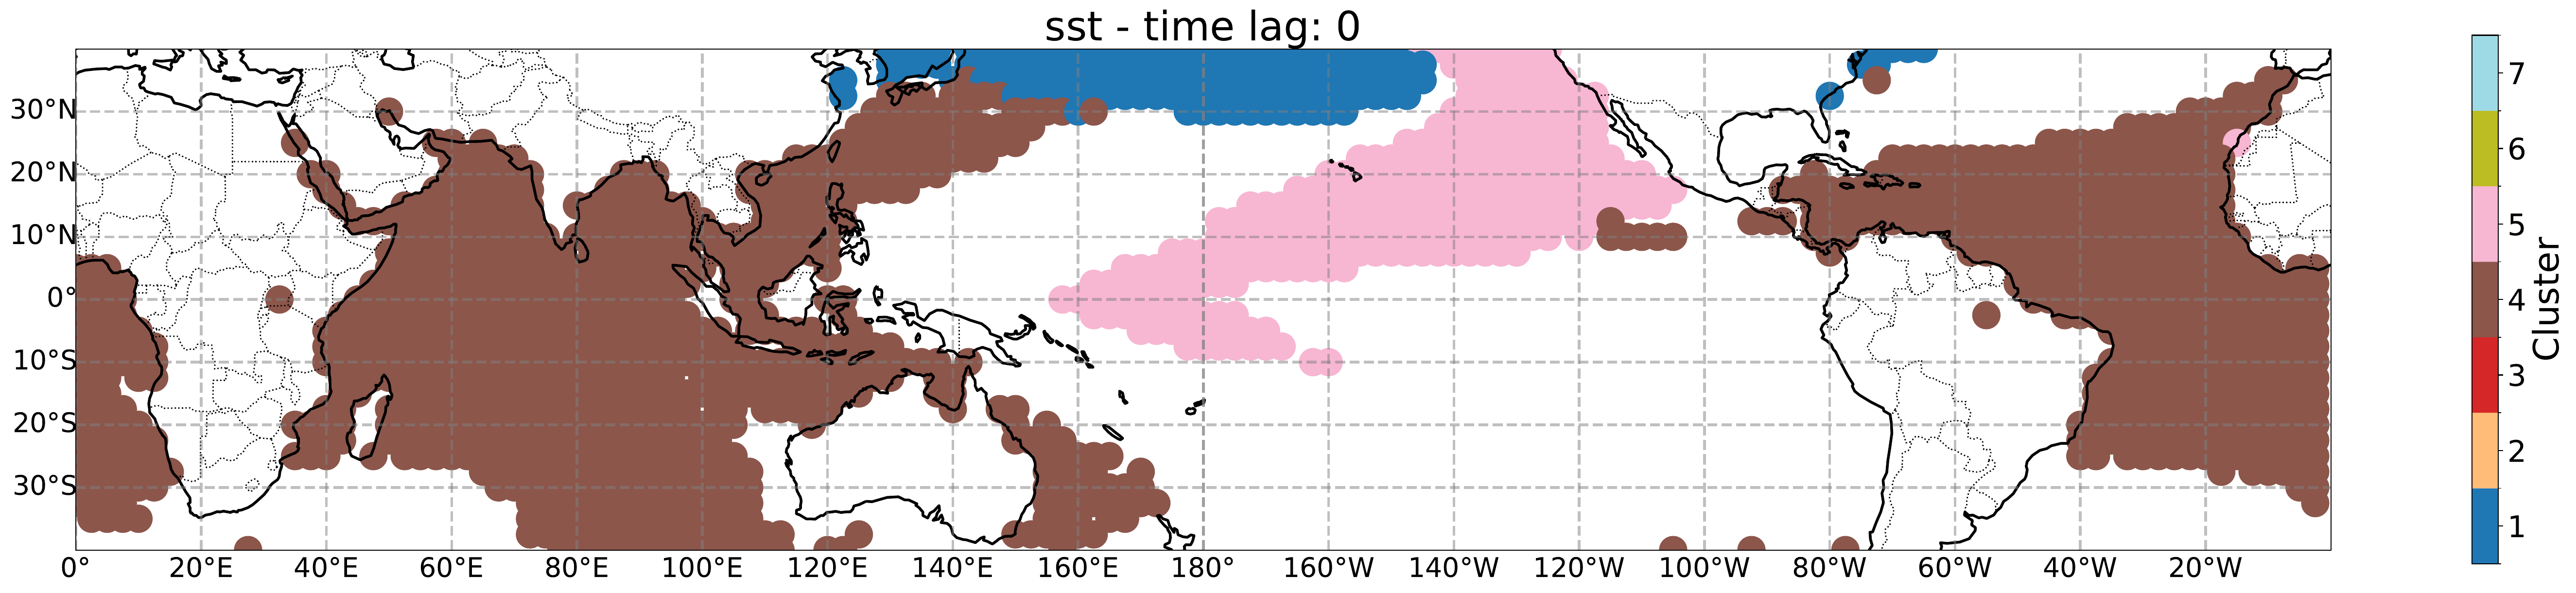

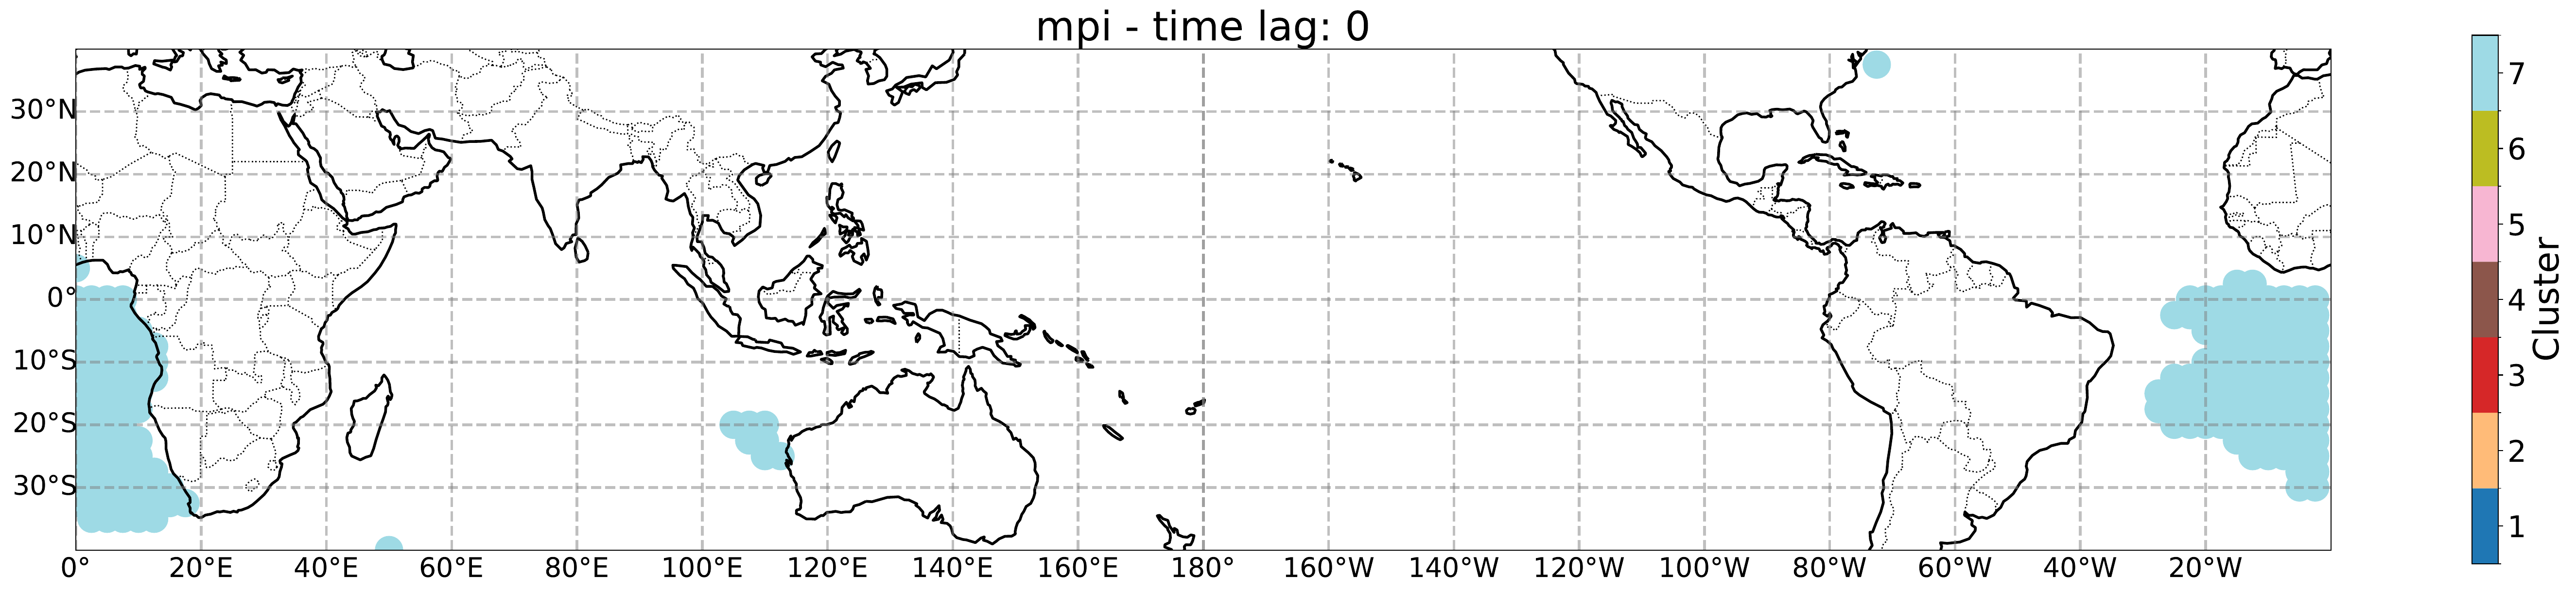

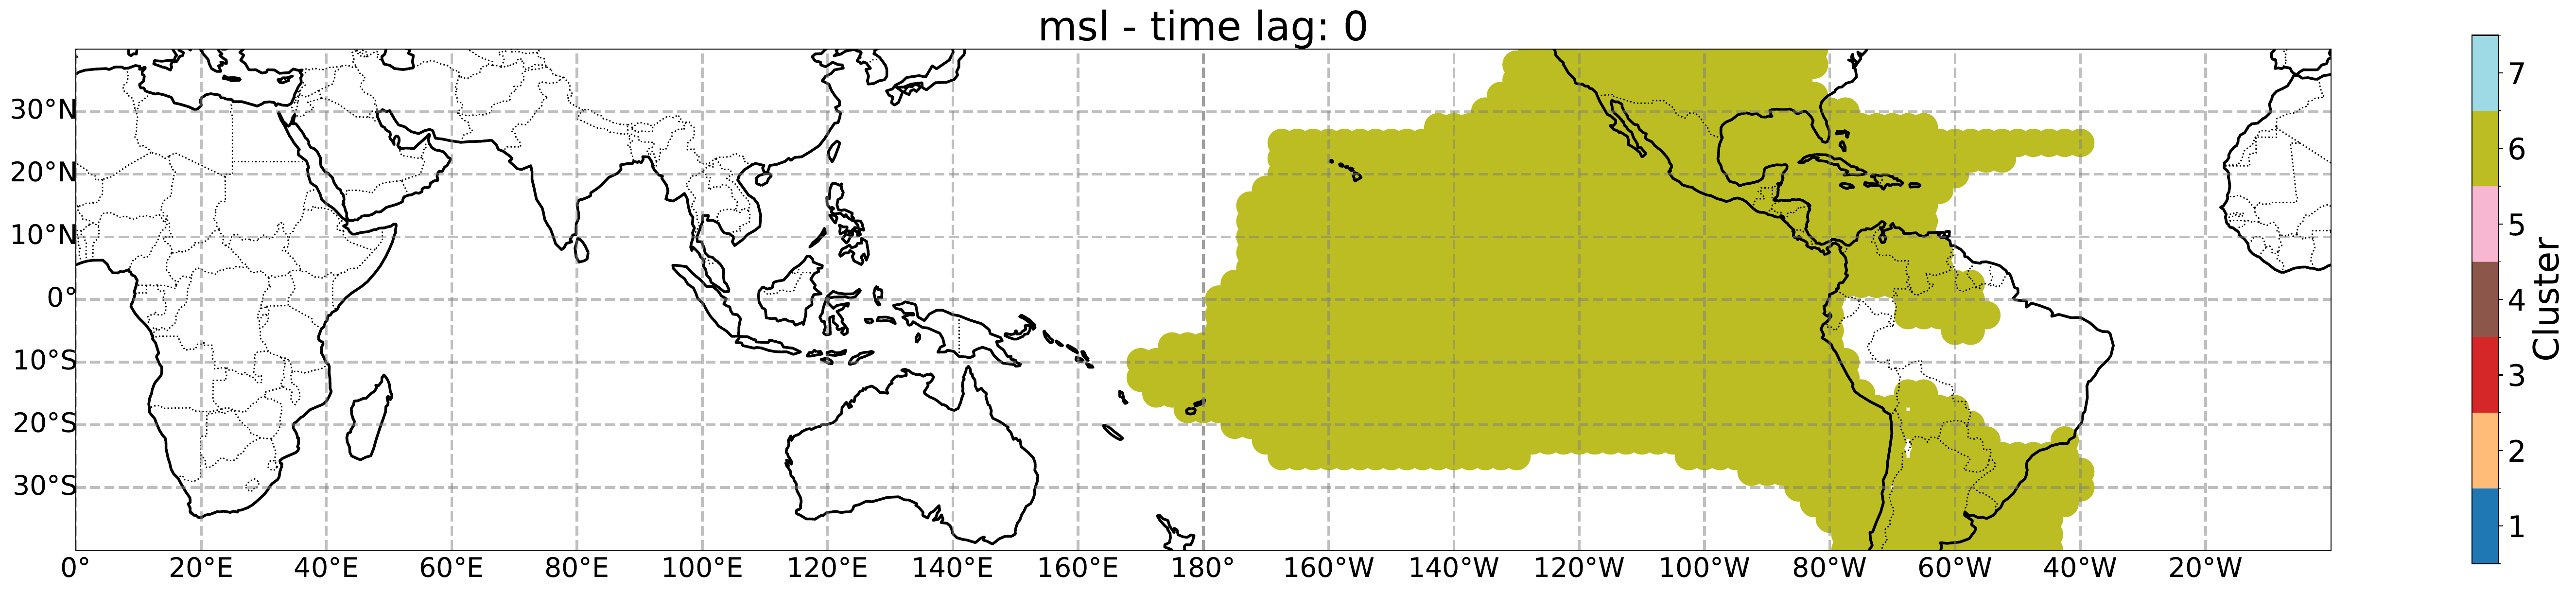

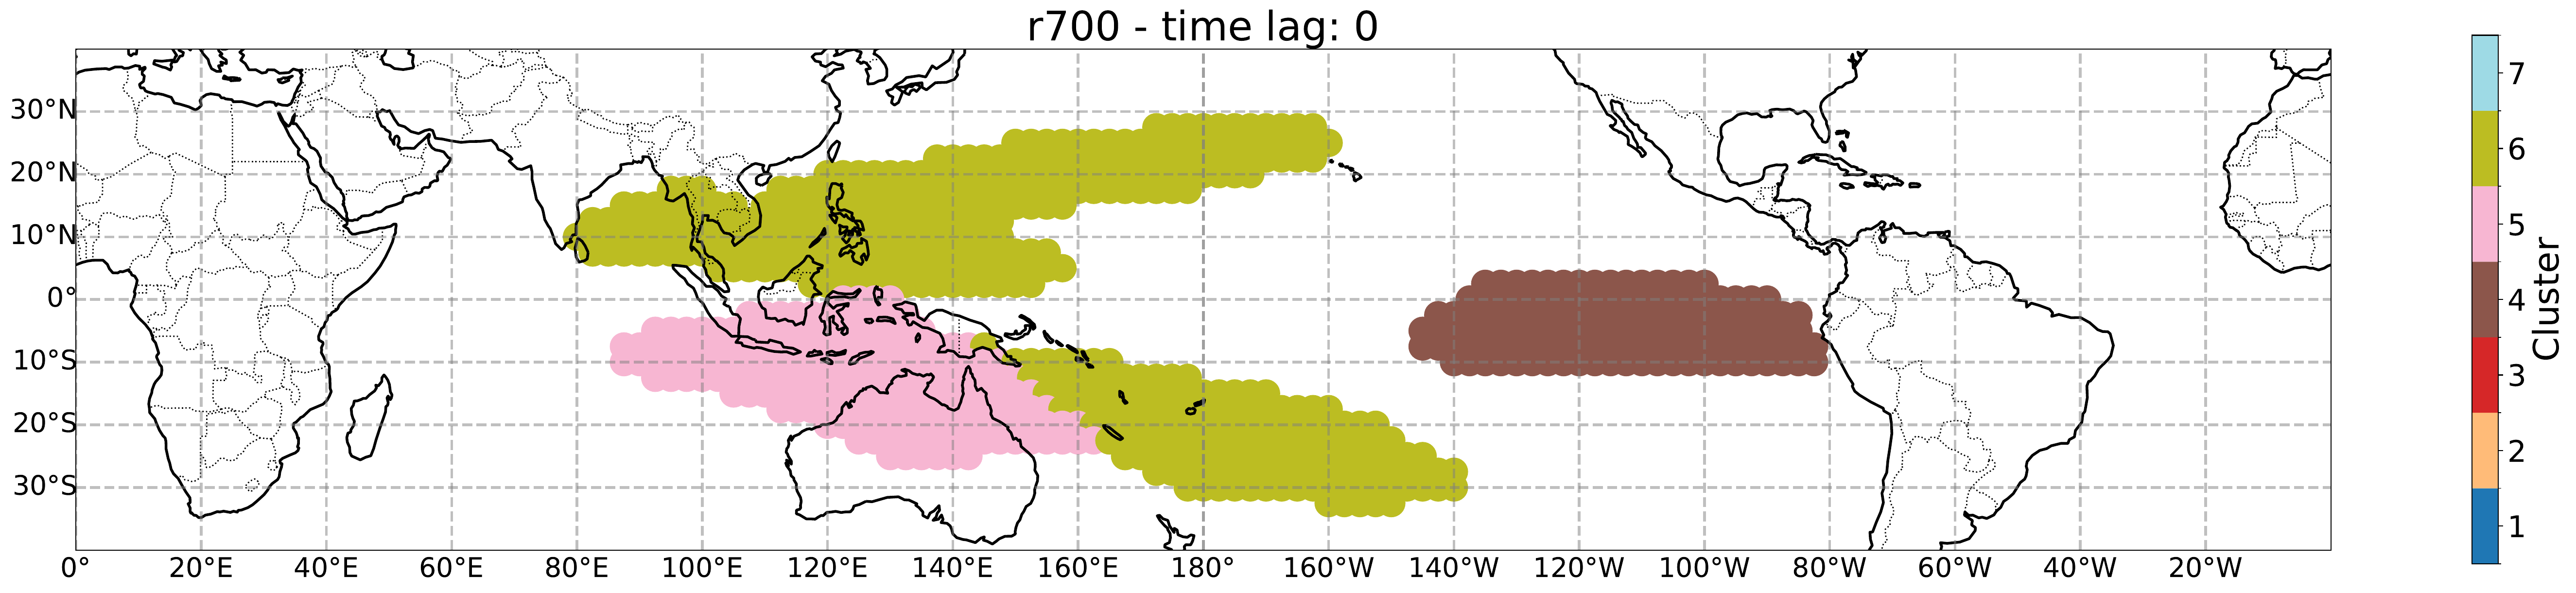

In [8]:
# Get in the folder containing the results of the simulations
results_dir = os.path.join(fs_dir, 'results')
best_sim_dir = os.path.join(results_dir, BASIN, best_sim.name)
figures_dir = os.path.join(best_sim_dir, 'figures')
selected_clusters_dir = os.path.join(figures_dir, 'clusters_selected')
# Load and print the figures of the clusters selected
figs_clusters = glob.glob(os.path.join(selected_clusters_dir, '*.pdf'))
for fig_path in figs_clusters:
    img = ut.load_pdf_convert_to_image(fig_path)
    display(img)